# Finding the Best Neighborhood in Pittsburgh
#### Team Pythons: Ethan Rubenstein, Gray Cleric, Teresa Davison

## Part 1

## To find the best neighborhood in Pittsburgh, we will consider three factors: number of restaurants, amount of arrests, and average property value. Each metric is explained in more detail in their respective subsections, which can be found immediately below this cell.

# Section 1.1: Arrest Data (Gray Cleric)
## Introduction 
 Hello! I used data from the local City of Pittsburgh police to better examine which areas in Pittsburgh would be safer to live in.  My group felt that viewing crimerates across different neighborhoods is vital in choosing the best one because safety is essential to both our well-being and enjoyment within any given neighborhood.  If the neighborhood isn't safe, we aren't allowed to fully enjoy the neighborhood to its full extent.  I use this dataset to find the number of arrests that occur in each zipcode.  I use this number to better determine the areas where crime happens less frequently in hopes that it will aid us in our task of choosing the best neighborhood in Pittsburgh.  
### Data borrowed from https://data.wprdc.org/dataset/arrest-data

In [38]:
# Importing libraries that we will use throughout this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Importing the arrest data.  Note the information the data information provides.  
# The Arrest Data is very specfic about the location/nature of arrest but  excludes the personal information of the arrestee.  
arrest_pandas = pd.read_csv("ArrestData.csv")
arrest_pandas.head()

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551
1,1974456,16144120,31.0,M,W,2016-08-03T14:55:00,"4200 Block Steubenville PKE Pittsburgh, PA 15205",13(a)(16) Possession of Controlled Substance,"4200 Block Steubenville PKE Pittsburgh, PA 15205",Outside City,OSC,5599.0,NaN,NaN,-80.088018,40.440136
2,1974466,16144165,63.0,F,B,2016-08-03T16:45:00,"900 Block Freeport RD Fox Chapel, PA 15238",3929 Retail Theft.,"900 Block Freeport RD Fox Chapel, PA 15238",Westwood,5,2811.0,9.0,2.0,-79.891803,40.486625
3,1974550,16145257,25.0,F,W,2016-08-05T02:36:00,"Foreland ST & Cedar AV Pittsburgh, PA 15212",5503 Disorderly Conduct. / 5505 Public Drunken...,"Foreland ST & Cedar AV Pittsburgh, PA 15212",East Allegheny,1,2304.0,1.0,1.0,-80.001939,40.454080
4,1974596,16145962,25.0,M,B,2016-08-06T02:00:00,"900 Block Woodlow ST Pittsburgh, PA 15205",2702 Aggravated Assault. / 2705 Recklessy Enda...,"900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,5,2814.0,2.0,5.0,-80.052204,40.445900


In [40]:
# In this cell, I better reorganize the data to infomration that is more relevant to finding out which zipcodes/neighborhoods have the lowest crime.  
# Note: Some of the zipcodes aren't all legitimate zipcodes. Some are other zones/areas of Pittsburgh that do not have zipcodes to accompany them.
# For example, all of the zipcodes with "1" are from "Zone 1". I also make a column for zipcodes by pulling the last string in the arrestlocation data. 
# I lastly sort by those zipcode values in ascending order.  

df = pd.DataFrame(arrest_pandas)
df['ZipCodes'] = df['ARRESTLOCATION'].str.split().str[-1]
df = df.drop(columns = ['INCIDENTLOCATION', 'INCIDENTZONE', 'INCIDENTTRACT', 'COUNCIL_DISTRICT','PUBLIC_WORKS_DIVISION','X', 'Y'])
df = df.sort_values(by = ['ZipCodes'])
df.head(1000)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTNEIGHBORHOOD,ZipCodes
24648,2005806,18188634,18.0,F,W,2018-09-24T21:49:00,Zone 1,2701 Simple Assault. / 2718(a)(1) Strangulatio...,NaN,1
1481,1976306,16179695,26.0,F,B,2016-10-04T22:45:00,Zone 1,2701 Simple Assault. / 2701(b)(2) Simple Assau...,NaN,1
36113,2020459,19220662,56.0,M,W,2019-10-29T09:48:00,Zone 1,3304 Criminal Mischief. / 3127(a) Indecent exp...,NaN,1
36109,2020455,19220436,37.0,M,W,2019-10-29T01:00:00,Zone 1,3304 Criminal Mischief. / 5505 Public Drunkenn...,NaN,1
10117,1987270,17119676,28.0,F,B,2017-06-28T12:56:00,Zone 1,2706 Terroristic Threats. / 2904 Interference ...,NaN,1
...,...,...,...,...,...,...,...,...,...,...
9026,1986010,17099708,23.0,M,W,2017-05-31T18:40:00,4400 Block Stanton AV & McCandless AV Pittsbur...,13(a)(16) Possession of Controlled Substance /...,Stanton Heights,15201
8634,1985484,17091820,37.0,F,W,2017-05-20T00:39:00,"5100 Block Butler ST Pittsburgh, PA 15201","6308(a) Underage Purchase, Consume, Possessed ...",Upper Lawrenceville,15201
40796,2027004,20092068,40.0,M,W,2020-05-18T11:45:00,"200 Block 57th ST Pittsburgh, PA 15201",9093 Indirect Criminal Contempt,Stanton Heights,15201
42099,2028843,20127858,59.0,M,W,2020-07-11T22:53:00,"Woodbine ST & Arcade WY Pittsburgh, PA 15201",3323 Stop Signs and Yield Signs. / 3731 Drivin...,Stanton Heights,15201


In [41]:
# This code cell finds the count of each unique zip code in the dataset. As shown by the numbers displayed, there is a great range in the counts across the varying zipcodes.  
#The left column signifies zipcode and the right column shows its count.   

zipcodeFrequency = df['ZipCodes']
zipcodeCounts = (zipcodeFrequency).value_counts()
zipcodeCounts = zipcodeCounts.to_frame()
zipcodeCounts.index.name = "Zip_Codes"
zipcodeCounts.columns = ["Counts"]
print(zipcodeCounts)

           Counts
Zip_Codes        
15219       14814
15212        5708
15210        3223
15206        2786
15203        2149
...           ...
17931           1
15317           1
16001           1
15690           1
16648           1

[130 rows x 1 columns]


This first bar graph just looks at the distribution of the zipcode counts.  It is a pandas bar graph so the representation is not the best but as you can see, the distribution is very uneven accross the zipcodes.  The counts seem to grow seemingly exponentially as the zipcodes go into more densely populated areas,
which makes sense. In essence, more people correlate with higher total arrests.

<AxesSubplot:ylabel='Zip_Codes'>

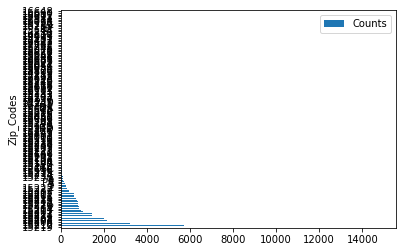

In [42]:
zipcodeCounts.plot.barh(rot = 0)

In [43]:
# Here we create a column for the rank of the zipcode counts by percentile and we assign a percentile rank for each.  We will use these percentiles in accordance with our metric to determine the number of points to assign each zipcode.  
zipcodeCounts['pct_rank'] = zipcodeCounts.rank(pct = True)
zipcodeCounts.index.name = "Zip_Codes"
zipcodeCounts.columns = ['Count', 'Pct_Rank']
print(zipcodeCounts)

           Count  Pct_Rank
Zip_Codes                 
15219      14814  1.000000
15212       5708  0.992308
15210       3223  0.984615
15206       2786  0.976923
15203       2149  0.969231
...          ...       ...
17931          1  0.165385
15317          1  0.165385
16001          1  0.165385
15690          1  0.165385
16648          1  0.165385

[130 rows x 2 columns]


In [44]:
# This cell is where the metric is implemented.  We make points based off of the percentiles we just assigned and our point system where the top 20% is 5 points and the bottom 20% is 1 point.
# For the arrest data, less is more in the sense that the lowest crimes are the best. 
# The lowest in terms of count percentile will be given 5 points and in contrast, the highest in terms of count percentile will be the worst in terms of number of crimes committed.  
condition = [
    (zipcodeCounts['Pct_Rank'] <= .2),
    (zipcodeCounts['Pct_Rank'] > .2) & (zipcodeCounts['Pct_Rank'] <= .4),
    (zipcodeCounts['Pct_Rank'] > .4) & (zipcodeCounts['Pct_Rank'] <= .6),
    (zipcodeCounts['Pct_Rank'] > .6) & (zipcodeCounts['Pct_Rank'] <= .8),
    (zipcodeCounts['Pct_Rank'] > .8)]

points = ['5', '4', '3', '2', '1']
zipcodeCounts['Points'] = np.select(condition, points)
zipcodeCounts.sort_values(by=['Points', 'Zip_Codes'],inplace=True)
zipcodeCounts.index.name = "Zip_Codes"
zipcodeCounts.columns = ['Count', 'Pct_Rank', 'Points']
zipcodeCounts.head(130)

,Count,Pct_Rank,Points
Zip_Codes,,,
1,249,0.815385,1
15201,605,0.853846,1
15203,2149,0.969231,1
15204,834,0.915385,1
15205,385,0.838462,1
...,...,...,...
17931,1,0.165385,5
18801,1,0.165385,5
19403,1,0.165385,5


In [45]:
# Here I filter out all the zipcodes which had received 5 points.  I cross-reference these with the neighborhoods that the zipcodes respond to in order to apply the metric to my groupmates' data.  

def filter_equal_to(x, threshold):
    return x['Points'] == threshold

bestZips = zipcodeCounts.groupby(zipcodeCounts.index).filter(filter_equal_to, threshold = '5')
bestZips.head(5)

,Count,Pct_Rank,Points
Zip_Codes,,,
12226,1,0.165385,5
14219,1,0.165385,5
14614,1,0.165385,5
15028,1,0.165385,5
15044,1,0.165385,5


### Visualizing the data

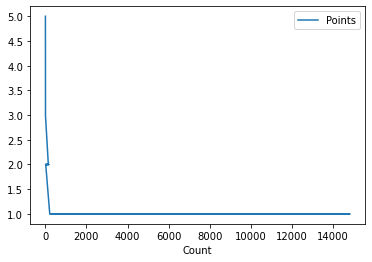

In [46]:
# This line graph shows numerically where the data goes from 5 points down to 1 point. 
# As you can see, it is extremely quickly due to super rapid growth of the zipcode counts as it progresses from more rural to more urban areas.  

ax = plt.gca()

zipcodeCounts.reset_index(inplace=True, drop = True)
zipcodeCounts = zipcodeCounts.astype(int)

zipcodeCounts.plot(kind='line',x = 'Count', y='Points',ax=ax)

plt.show()

## Analysis: Crime Data 

The nature of the arrest data on its own does not allow me to conclusively decide which neighborhood on its own.  I found that only when the arrest data is combined with the restaurant data and property data with population taken into account (in the end of the Final Report notebook) does it become useful to us in our quest in deciding the best neighborhood.  After we do this, I can conclude that Squirrel Hill is the best neighborhood.  We take a look and see which neighborhoods have the best average property value and restaurants in the area.  This results in a 7 way tie across different neighborhoods.  The crime rates from this dataset and the population of each neighborhood allows me to see which one is best- which is Squirrel Hill in this case.  

If I went back and redid this project, I would have taken into account population density and cross-referenced it with how often different neighborhoods appear in the arrest data to begin with. I saw some of the other groups use it in this manner and their results would much more conclusive even after looking at the dataset on its own.  I originally decided to use the lowest counts of arrest because I thought the points we assigned to the neighborhoods with the lowest number of arrests would better intersect with the points my other group members assigned to their dataset.  Unfortunately, this wasn't really the case so we had to into account population density in combination with the arrest data when we found the best neighborhoods for the other datasets.  

I initially had trouble organizing the arrest data by neighborhood at first.  Some members of the data included the neighborhood, others did not.  This made initial analysis/managing of the dataset very difficult.  My solution to this was pulling the zipcode from each arrestlocation as each arrestlocation had the zipcode as the last element.  I pulled the zipcodes from this element and used this information to compare the neighborhoods.  I recognize that the zipcodes do have overlap but the general trend of crime across different areas is still very useful in determining where the crime occurs in the City of Pittsburgh

In conclusion, Squirrel Hill is the best neighborhood overrall.  Especially with this being such a commonly used dataset across all the groups, I know that there are improvements I could have made specfically to this dataset.  As I mentioned, I could have taken into account population density and severity of crime, as other groups have done.  I am glad, however, that I have seen that it can be done in so many different ways.  This gives me a much greater perspective in the sense that we can all find different results/approaches in attacking the same problem. I feel like in many ways, this is what Computing and Information is all about. With that said, I really enjoyed this assignment and working with my fellow  groupmembers.  Thank you for your time and I hope you have a great summer!! 

# Section 1.2: Property Data (Ethan Rubenstein)
## Introduction 
The perception of a neighborhood often stems from the quality of its buildings and home. This dataset seeks to capture that perception quantitatively, rather than empirically by driving through each neighborhood and noting the condition of each house and building. To accomplish this, I use a dataset that includes all property sales around Pittsburgh since 2013, including the sale price and zip code for each property. In the analysis, I group all properties by zip code, and then find the mean to determine the average sold price since 2013, which I refer to as the property value. 
### Data borrowed from https://data.wprdc.org/dataset/real-estate-sales

In [47]:
# Importing the data
property_data = pd.read_csv("PghPropertySaleData.csv", low_memory = False)
# Previewing the data
property_data.head(5)

,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESSDIR,PROPERTYADDRESSSTREET,PROPERTYADDRESSSUF,PROPERTYADDRESSUNITDESC,PROPERTYUNITNO,PROPERTYCITY,PROPERTYSTATE,...,MUNIDESC,RECORDDATE,SALEDATE,PRICE,DEEDBOOK,DEEDPAGE,SALECODE,SALEDESC,INSTRTYP,INSTRTYPDESC
0,1075F00108000000,4720.0,,NaN,HIGHPOINT,DR,NaN,NaN,GIBSONIA,PA,...,Hampton,2012-09-27,2012-09-27,120000.0,15020,356,3,LOVE AND AFFECTION SALE,DE,DEED
1,0011A00237000000,0.0,,NaN,LOMBARD,ST,NaN,NaN,PITTSBURGH,PA,...,3rd Ward - PITTSBURGH,2015-01-06,2015-01-06,1783.0,TR15,00002,2,CITY TREASURER SALE,TS,TREASURER DEED
2,0011J00047000000,1903.0,,NaN,FORBES,AVE,NaN,NaN,PITTSBURGH,PA,...,1st Ward - PITTSBURGH,2012-10-26,2012-10-26,4643.0,TR13,003,2,CITY TREASURER SALE,TS,TREASURER DEED
3,0113B00029000000,479.0,,NaN,ROOSEVELT,AVE,NaN,NaN,PITTSBURGH,PA,...,Bellevue,2017-03-27,2017-03-06,0.0,16739,166,3,LOVE AND AFFECTION SALE,CO,CORRECTIVE DEED
4,0119S00024000000,5418.0,,NaN,CARNEGIE,ST,NaN,NaN,PITTSBURGH,PA,...,10th Ward - PITTSBURGH,2015-02-04,2015-02-04,27541.0,TR15,00059,GV,GOVERNMENT SALE,TS,TREASURER DEED


In [48]:
# In the preview, I noticed that the property in the fourth row sold for a price of $0.
# Looking through the .dbf file, I noticed that there are several other extremely low sold prices, such as $0, $1, and $10. 
# Therefore, I am only considering prices above $1,000 to mitigate the infuence of global outliers. 
property_data = property_data[property_data.PRICE > 1000]
# In importing the CSV file, the zip codes were turned into floats. This will cast them back into the int data type
property_data['PROPERTYZIP'] = property_data['PROPERTYZIP'].astype(int)

In [49]:
# Finding the mean of the property sold prices for all properties sharing the same zip code
price_property_data = property_data[['PROPERTYZIP','PRICE']].groupby(['PROPERTYZIP']).mean()
price_property_data

,PRICE
PROPERTYZIP,
15003,86601.668605
15005,529842.319527
15006,73238.805970
15007,172196.555556
15012,119375.000000
...,...
15642,90610.318182
15668,233826.666667
16046,408128.726704


In [50]:
# Rounding the mean property sales prices to the nearest dollar to make the data more comprehensible
price_property_data['PRICE'] = price_property_data['PRICE'].astype(int)
# Sorting the data by price
price_property_data.sort_values(by=['PRICE'],inplace=True)
price_property_data.head(10)

,PRICE
PROPERTYZIP,
15028,24032
15089,24272
15104,34736
15110,36851
15045,47284
15035,47925
15112,52032
15210,59941
15034,60619


### Establishing a points system and price brackets
Zip codes with properties within a certain threshold will be assigned a fixed number of points.          

Team members' data sets also utilize a point system.         

The neighborood with the highest combined number of points will be considered the best.

In [51]:
# First, price brackets need to be established. To do this, I will divide the distribution into five tiers, based on percentiles.

# Creating a new column called "Percentile Rank", which shows the percentage of prices that any one price is greater than.
price_property_data['Percentile Rank'] = price_property_data.PRICE.rank(pct = True)

In [52]:
# Now, I am creating conditions for the program to check in order to set a point value based on the Percentile Rank values. 

conditions = [
    (price_property_data['Percentile Rank'] <= .2),
    (price_property_data['Percentile Rank'] > .2) & (price_property_data['Percentile Rank'] <= .4),
    (price_property_data['Percentile Rank'] > .4) & (price_property_data['Percentile Rank'] <= .6),
    (price_property_data['Percentile Rank'] > .6) & (price_property_data['Percentile Rank'] <= .8),
    (price_property_data['Percentile Rank'] > .8)]
# The points work with the above conditions. If the first condition is met (percentile rank below .2), one point is assigned.
# If the second condition is met (percentile rank below or equal to .4 and greater than .2), then two poitns are assigned.
# This method gives more points to zip codes with higher percentile prices.
points = ['1', '2', '3', '4', '5']
# Making a new column called "Points" and adding point values based on the above conditions.
price_property_data['Points'] = np.select(conditions, points)
# Sorting the data first by points, and then by price.
price_property_data.sort_values(by=['Points', 'PRICE'],inplace=True, ascending=False)
price_property_data.head(5)


,PRICE,Percentile Rank,Points
PROPERTYZIP,,,
15275,6003730,1.000000,5
15276,1850783,0.991453,5
15222,1274521,0.982906,5
15086,911245,0.974359,5
15142,570302,0.965812,5


### As seen above, the best neighborhood judged purely from property values is 15275, which is Pittsburgh. There is no specific neighborhood attached to that zip code, nor the runner-up, so I will conclude that 15222 - Downtown - is the best neighborhood.
### Visualizing the data

(-0.5, 116.5, 0.0, 6303916.5)

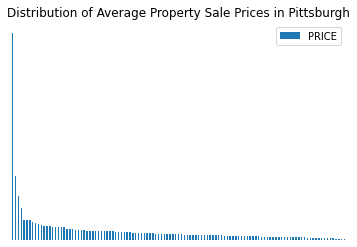

In [53]:
price_property_data.reset_index(inplace=True)
price_property_data = price_property_data.astype(int)
graph = price_property_data.plot.bar(x ='PROPERTYZIP',y='PRICE', title="Distribution of Average Property Sale Prices in Pittsburgh")
plt.axis('off')


### As we can see, there is one major outlier in the form of zipcode 15275, with an average property value of 6 million dollars. 

## Analysis: Property Values
While the methodology is technically correct, the results of this dataset point out some flaws in using it solely as a determinant for finding the best neighborhood in Pittsburgh. For example, the major outlier - zip code 15275 - has an average property sale price of over 6 million dollars. This is because it houses an industrial park, which consists of several extremely high-value buildings, and few parcels of land or houses that could bring the average property sale price down. Although the type of property was not included in the raw data, I think that controlling for the type of property (perhaps narrowing it down to only homes) would present a fairer picture of Pittsburgh's property values. Considering the many expensive commercial buildings in Downtown Pittsburgh, it is unsurprising that it ranked within the top three neighborhoods according to this metric. If the data extended farther back than 2013, then it is possible that Downtown could have a mean property value in the millions as well because of costly buildings sold before that year. Ultimately, this dataset should not be used alone to determine the best neighborhood, but using the overarching metric of percentiles and points, it allows enough leeway to not have the larger commercial districts dominate the scoreboard. 

# Section 1.3 : Restaurant Data (Teresa Davison)
This data set is a set of all of the restaurants in Allegheny County with geographic locations including zip code, size, description of use, and a "status" ranging from 0 to 7 to indicate if the restaurant is currently open.
### Data borrowed from https://data.wprdc.org/dataset/allegheny-county-restaurant-food-facility-inspection-violations/resource/112a3821-334d-4f3f-ab40-4de1220b1a0a


In [54]:
# Importing the data
restaurants_all = pd.read_csv("r.csv")

First, I remove the few restaurants that are outside of Pittsburgh and those with a value of 0 or 1 for their status, which indicates that they are closed.


In [55]:
query_mask = restaurants_all['status'] > 1
zip_mask_low = restaurants_all['zip'] > 14999.0
zip_mask_high = restaurants_all['zip'] < 16000.0
open_restaurants = restaurants_all[query_mask]
open_restaurants = open_restaurants[zip_mask_low]
open_restaurants = open_restaurants[zip_mask_high]
open_restaurants = open_restaurants[open_restaurants['zip'].notnull()]
open_restaurants.head(5)

<ipython-input-55-b236f237d444>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  open_restaurants = open_restaurants[zip_mask_low]
<ipython-input-55-b236f237d444>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  open_restaurants = open_restaurants[zip_mask_high]


,id,facility_name,num,street,city,state,zip,municipal,category_cd,description,...,bus_st_date,bus_cl_date,seat_count,noroom,sq_feet,status,placard_st,x,y,address
1,10781,Hill Top Lodge #151,128-30,Ormsby Ave,Pittsburgh,PA,15210.0,Mt Oliver,250,Social Club-Bar Only,...,1984-06-17,NaN,35.0,NaN,NaN,7,NaN,NaN,NaN,"128-30 Ormsby Ave Pittsburgh, PA 15210"
2,10693,The Suburban Room,3113,W Liberty Ave,Pittsburgh,PA,15216.0,Dormont,201,Restaurant with Liquor,...,1984-06-17,NaN,41.0,NaN,NaN,7,1.0,NaN,NaN,"3113 W Liberty Ave Pittsburgh, PA 15216"
3,10707,Hyd A Way Bar,NaN,Box 39,Morgan,PA,15064.0,South Fayette,201,Restaurant with Liquor,...,1987-03-01,NaN,30.0,NaN,NaN,7,NaN,NaN,NaN,"Box 39 Morgan, PA 15064"
5,10730,Aleppo Firemens Club,NaN,Weber Rd,Sewickley,PA,15143.0,Aleppo,250,Social Club-Bar Only,...,1984-06-17,NaN,75.0,NaN,NaN,7,NaN,NaN,NaN,"Weber Rd Sewickley, PA 15143"
7,10655,Ames,5775,Baptist Rd,Bethel Park,PA,15102.0,Bethel Park,212,Chain Restaurant without Liquor,...,1999-04-15,NaN,13.0,NaN,NaN,7,NaN,-80.014728,40.348882,"5775 Baptist Rd Bethel Park, PA 15102"


Then I count up the number of open restaurants within a certain zipcode by keeping track of the data in a dictionary, using the zipcode as a key and incrementing the value associated with it.

In [56]:
zipcode_counter = dict()

for row in open_restaurants.index:
    zipc = open_restaurants.loc[row, "zip"]
    
    if zipc not in zipcode_counter:
        zipcode_counter[zipc] = 1
    else:
        zipcode_counter[zipc] = zipcode_counter[zipc] + 1

zipcode_counter
zip_sorted = dict(sorted(zipcode_counter.items(), key=lambda item: item[1]))
zip_sorted

{15047.0: 1,
 15445.0: 1,
 15259.0: 1,
 15642.0: 1,
 15244.0: 1,
 15022.0: 1,
 15312.0: 1,
 15693.0: 1,
 15038.0: 1,
 15009.0: 1,
 15367.0: 1,
 15301.0: 1,
 15644.0: 1,
 15650.0: 1,
 15085.0: 1,
 15083.0: 1,
 15061.0: 1,
 15087.0: 1,
 15089.0: 1,
 15610.0: 1,
 15230.0: 2,
 15690.0: 2,
 15601.0: 2,
 15317.0: 3,
 15321.0: 3,
 15082.0: 3,
 15006.0: 3,
 15020.0: 3,
 15242.0: 3,
 15127.0: 4,
 15332.0: 4,
 15051.0: 4,
 15001.0: 4,
 15015.0: 5,
 15240.0: 5,
 15063.0: 6,
 15018.0: 6,
 15276.0: 6,
 15057.0: 7,
 15075.0: 7,
 15032.0: 7,
 15088.0: 8,
 15046.0: 8,
 15260.0: 9,
 15068.0: 10,
 15064.0: 11,
 15003.0: 11,
 15030.0: 11,
 15026.0: 12,
 15142.0: 14,
 15031.0: 15,
 15282.0: 15,
 15035.0: 17,
 15007.0: 18,
 15056.0: 20,
 15091.0: 24,
 15225.0: 27,
 15140.0: 30,
 15086.0: 30,
 15076.0: 32,
 15148.0: 34,
 15014.0: 39,
 15243.0: 41,
 15034.0: 42,
 15133.0: 42,
 15126.0: 44,
 15112.0: 47,
 15261.0: 48,
 15135.0: 50,
 15129.0: 55,
 15144.0: 57,
 15045.0: 60,
 15116.0: 67,
 15123.0: 70,
 15211.0

### Visualizing the Data

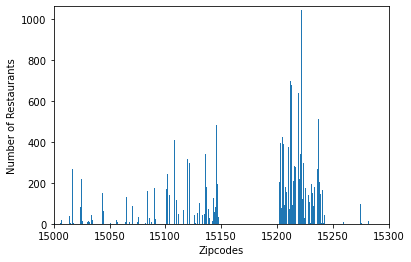

123.12949640287769


In [57]:
names = list(zipcode_counter.keys())
values = list(zipcode_counter.values())

plt.bar(names, values)
plt.xlabel("Zipcodes")
plt.ylabel("Number of Restaurants")
plt.axis([15000, 15300, 0, 1060])
plt.show()

average = sum(zip_sorted.values()) / len(zip_sorted)
print(average)

Plotting this data, we find that there is a very wide range from 0 to 1041 and a mean of 124 restaurants per zipcode.

In [58]:
#all_values = zipcode_counter.values()
#max_value = max(all_values)

#print(max_value)

max_key = max(zipcode_counter, key=zipcode_counter.get)
print(max_key)

min_key = min(zipcode_counter, key=zipcode_counter.get)
print(min_key)


15222.0
15047.0


The top ten zipcodes with the most restaurants and their corresponding neighborhoods are: 
* 15222.0: 1041 - Strip District
* 15212.0: 694 - North Shore/North Side
* 15213.0: 677 - Oakland
* 15219.0: 639 - Hill District
* 15237.0: 509 - Ross Township
* 15146.0: 482 - Monroeville
* 15205.0: 423 - Crafton
* 15108.0: 408 - Coraoplis
* 15235.0: 396 - Penn Hills
* 15203.0: 392 - South Side


According to our metric, we divide the data into fifths and award points to the total of each of the zipcodes:
 
 
 
 
 
 

In [59]:
print(len(zip_sorted))

zipcode_points_restaurants = dict()
i = 1

for key in zip_sorted:
    zipcode_points_restaurants[key] = i // 28 + 1
    i = i + 1
    
zipcode_points_restaurants

139


{15047.0: 1,
 15445.0: 1,
 15259.0: 1,
 15642.0: 1,
 15244.0: 1,
 15022.0: 1,
 15312.0: 1,
 15693.0: 1,
 15038.0: 1,
 15009.0: 1,
 15367.0: 1,
 15301.0: 1,
 15644.0: 1,
 15650.0: 1,
 15085.0: 1,
 15083.0: 1,
 15061.0: 1,
 15087.0: 1,
 15089.0: 1,
 15610.0: 1,
 15230.0: 1,
 15690.0: 1,
 15601.0: 1,
 15317.0: 1,
 15321.0: 1,
 15082.0: 1,
 15006.0: 1,
 15020.0: 2,
 15242.0: 2,
 15127.0: 2,
 15332.0: 2,
 15051.0: 2,
 15001.0: 2,
 15015.0: 2,
 15240.0: 2,
 15063.0: 2,
 15018.0: 2,
 15276.0: 2,
 15057.0: 2,
 15075.0: 2,
 15032.0: 2,
 15088.0: 2,
 15046.0: 2,
 15260.0: 2,
 15068.0: 2,
 15064.0: 2,
 15003.0: 2,
 15030.0: 2,
 15026.0: 2,
 15142.0: 2,
 15031.0: 2,
 15282.0: 2,
 15035.0: 2,
 15007.0: 2,
 15056.0: 2,
 15091.0: 3,
 15225.0: 3,
 15140.0: 3,
 15086.0: 3,
 15076.0: 3,
 15148.0: 3,
 15014.0: 3,
 15243.0: 3,
 15034.0: 3,
 15133.0: 3,
 15126.0: 3,
 15112.0: 3,
 15261.0: 3,
 15135.0: 3,
 15129.0: 3,
 15144.0: 3,
 15045.0: 3,
 15116.0: 3,
 15123.0: 3,
 15211.0: 3,
 15139.0: 3,
 15204.0: 3,

# Part 2: Combining the Datasets
### In this project, we will consider three factors to determine which neighborhood in Pittsburgh is the best: amount of arrests, property values, and number of restaurants. To standardize these factors, one overarching metric will be used. Each zip code will be assigned points, based on which of the five percentiles its data falls into. For example, a zip code in the 99%th percentile of property values will earn five points, while a zip code in the 19%th percentile of arrest rates will earn 1 point.

In [60]:
crime_data = pd.read_csv('crime_data.csv')
property_data = pd.read_csv('property_data.csv')
restaurant_data = pd.read_csv('restaurant_data.csv')

## We hypothesize that at least one zipcode will earn the total 15 points. As a result, we will first look at only zip codes that earned five points. We will then combine them into one data frame and count the zip codes to see how many, if any, earned five points in each category.

In [61]:
# Finding all the zip codes where the total number of arrests is the lowest (5 points)
crime_data.astype(int)
crime_data_5s = crime_data.loc[crime_data['Points'] == 5]
crime_data_5s.head(5)

,Zip,Points
78,14219,5
79,15056,5
80,15071,5
81,14614,5
82,16503,5


In [62]:
# Finding all the zip codes where property values are the highest (5 points)
property_data = property_data.astype(int)
property_data_5s = property_data.loc[property_data['Points'] == 5]
property_data_5s.head(5)

,Zip,Points
0,15275,5
1,15276,5
2,15222,5
3,15086,5
4,15142,5


In [63]:
# Finding the zip codes with the most restaurants (5 points)
restaurant_data = restaurant_data.astype(int)
restaurant_data_5s = restaurant_data.loc[restaurant_data['Points'] == 5]
restaurant_data_5s.head(5)

,Zip,Points
111,15025,5
112,15220,5
113,15227,5
114,15102,5
115,15201,5


In [64]:
# Merging the crime and property data
crime_property_data_5s = pd.concat([property_data_5s,crime_data_5s], axis=0,ignore_index=True)
crime_property_data_5s

,Zip,Points
0,15275,5
1,15276,5
2,15222,5
3,15086,5
4,15142,5
...,...,...
59,15126,5
60,16693,5
61,16239,5
62,16830,5


In [65]:
# Making the final dataframe that includes all cases of zip codes that earned five points in any metric
final_data1 = pd.concat([crime_property_data_5s,restaurant_data_5s], axis=0,ignore_index=True)
final_data1.head(5)

,Zip,Points
0,15275,5
1,15276,5
2,15222,5
3,15086,5
4,15142,5


In [66]:
# Counting the zip codes to see which one(s) earned the most five-pointers
final_data1['Zip'].value_counts().head(10)


15219    2
15044    2
15212    2
15213    2
15222    2
15017    2
15217    2
15015    1
15201    1
15071    1
Name: Zip, dtype: int64

## This isn't what we expected. Seven zip codes tied for first. Now, we will narrow the best neighborhood down to those seven by looking for their corresponding rows in each dataset and adding their points together.


| Zipcode   | Neighborhood |
|-------|---               |
| 15219     |    Uptown, Herron Hill, & Schenley Heights |
| ~~15017~~     |     ~~Bridgeville~~        
~~15044~~       | ~~Gibsonia~~
15212       |  Northside
15213       | Oakland & Bellefield
15222       | Downtown
15217       | Squirrel Hill, Greenfield, & Browns Hill

## As you may notice, that Gibsonia and Bridgeville are marked out. That is because, while they are located in Allegheny County, those zip codes are not quite located in Pittsburgh, so they will be removed from the search.

## Now, we'll look to see if one zip code has more points than any of the others.

In [67]:
crime_data.query('Zip in (15219, 15212, 15213, 15222, 15217)')

,Zip,Points
3,15217,1
12,15213,1
16,15222,1
21,15212,1
22,15219,1


In [68]:
property_data.query('Zip in (15219, 15212, 15213, 15222, 15217)')

,Zip,Points
2,15222,5
5,15219,5
13,15213,5
14,15217,5
22,15212,5


In [69]:
restaurant_data.query('Zip in (15219, 15212, 15213, 15222, 15217)')

,Zip,Points
119,15217,5
135,15219,5
136,15213,5
137,15212,5
138,15222,5


## Wow, it looks like they all end up with the same number of points. Let's just check to see if there are no zip codes that earned 12 points by earning 4 points in each metric.

In [70]:
restaurant_data_4s = restaurant_data.loc[restaurant_data['Points'] == 4]
property_data_4s = property_data.loc[property_data['Points'] == 4]
crime_data_4s = crime_data.loc[crime_data['Points'] == 4]

crime_property_data_4s = pd.concat([property_data_4s,crime_data_4s], axis=0,ignore_index=True)

final_data2 = pd.concat([crime_property_data_4s,restaurant_data_4s], axis=0,ignore_index=True)
final_data2['Zip'].value_counts().head(10)


15102    2
15116    2
15101    2
15215    2
15084    2
15241    2
15668    2
15143    2
15231    2
15243    1
Name: Zip, dtype: int64

## There are no zip codes that earned 12 points. The five zip codes that we saw previously have an equal opportunity at being crowned the best neighborhood.                        

## We could continue to check that no other combination of points (like 3 in arrests, 4 in property value, and 5 in restaurants) adds up to more than 11, but at this point, something strange has come up. All five zip codes with 5 points in restaurants and property values received a score of 1 in crime. Let's look closer at how the crime metric works.

In [71]:
crime_data_5s.head(5)

,Zip,Points
78,14219,5
79,15056,5
80,15071,5
81,14614,5
82,16503,5


## The zipcodes that earned 5 points in arrests tend to be rural, smaller towns. This is beneficial for them, as the points system for arrest counts the total number of arrests and then breaks it into five brackets. Smaller towns are likely to have fewer recorded arrests, thus earning more points than more populated neighborhoods. To combat this bias, we can control for population and score based on arrest rates, not total recorded instances of arrests.

## For brevity, instead of making a new dataframe and going through the process of sorting and scoring the data again, we will determine which of the five zip codes has the lowest arrest rate.

| Zip | Population | Arrests since 2016 | Arrests/Resident|
|---------|-----|---------|---|
|15217 | 26,190 | 601 | .023
|15219 |16,514 |14,814 | .897
| 15213|28,265 | 924| .033
|15212 | 26,634|5708 | .214
|15222 | 4,700| 1822| .388

## Using the table above, we deterine that Squirrel Hill, Greenfield, & Browns Hill are the best neighborhoods, with Oakland & Bellefield coming in a close second place.

# Summary: Comparing the Overall Conclusion to Individual Conclusions

## Factor: Arrests
### Best neighborhood: Squirrel Hill
On its own, the arrests do not really help to conclusively pick the best neighborhood. However, whenever population density and the other two factors we measured are taken to account, it can be used as a means for comparing the safety of two neighborhoods. For example, squirrel hill has the lowest arrests/person after we take this aspect into account. Out of the neighborhoods that scored well in property value and in terms of restaurants, the arrest data allows us to narrow the ties of different neighborhoods down to a winner. In this case, the winner with the lowest crime rate included would be Squirrel Hill.


## Factor: Property Values
### Best neighborhood: Downtown
As previosuly stated, the property value metric is not the best to use on its own. The top three or so zip codes have such high property values because of the type of real estate that is dominant in those areas, but this becomes less of an issue when the metric is applied. The metric gives equal weight to each zip code in the above the 80th percentile, so a zip code with an average property value of 6 million is given the same amount of points as a zip code with an average property value of a couple hundred thousand dollars.

## Factor: Restaurants
### Best neighborhood: Strip District

## Overall best neighborhood: Squirrel Hill, Greenfield, and Browns Hill